In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


In [31]:
# Charger les données et préparer le DataLoader
import pandas as pd
data = pd.read_csv("datasets\hespress_proceced")


# Tokenisation simple
data['tokens'] = data['processed_text'].apply(lambda x: x.split())

# Construire un vocabulaire
vocab = build_vocab_from_iterator(data['tokens'], specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Transformer les textes en séquences d'entiers
data['encoded'] = data['tokens'].apply(lambda x: [vocab[token] for token in x])

# Remplir ou tronquer les séquences pour une longueur fixe
MAX_LEN = 50
data['padded'] = data['encoded'].apply(lambda x: x[:MAX_LEN] + [0] * max(0, MAX_LEN - len(x)))

In [32]:

# Définir le Dataset
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = torch.tensor(self.data.iloc[idx]['padded'], dtype=torch.long)
        label = torch.tensor(self.data.iloc[idx]['note'], dtype=torch.float)
        return text, label
dataset = TextDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [33]:
# Définir les modèles (RNN, BiRNN, GRU, LSTM)
class SequenceModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, model_type="RNN"):
        super(SequenceModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.model_type = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        elif model_type == "BiRNN":
            self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True, bidirectional=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * (2 if "Bi" in model_type else 1), 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Dernière sortie temporelle
        x = self.fc(x)
        return x

In [34]:
# Fonction d'entraînement
def train_model(model, dataloader, epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for texts, scores in dataloader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    return losses

In [35]:
# Fonction d'évaluation
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for texts, scores in dataloader:
            outputs = model(texts)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(scores.tolist())

    # Calculer le MSE
    mse = mean_squared_error(actuals, predictions)

    # Discrétisation des scores pour précision, rappel et F1-score
    thresholds = [2.5, 5.0, 7.5]
    discrete_actuals = [0 if x <= thresholds[0] else 1 if x <= thresholds[1] else 2 for x in actuals]
    discrete_predictions = [0 if x <= thresholds[0] else 1 if x <= thresholds[1] else 2 for x in predictions]

    precision = precision_score(discrete_actuals, discrete_predictions, average='weighted')
    recall = recall_score(discrete_actuals, discrete_predictions, average='weighted')
    f1 = f1_score(discrete_actuals, discrete_predictions, average='weighted')

    return mse, precision, recall, f1

In [36]:
# Visualisation des performances
def plot_metrics(metrics, models):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics_names = ["MSE", "Precision", "Recall", "F1-score"]
    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        ax.bar(models, metric)
        ax.set_title(metrics_names[i])
        ax.set_ylabel(metrics_names[i])
        ax.set_xlabel("Models")
    plt.tight_layout()
    plt.show()


In [39]:
# Définir les hyperparamètres
vocab_size = 10000  # Par exemple
embed_size = 100
hidden_size = 64
epochs = 200

# Entraîner et évaluer chaque modèle
models = ["RNN", "BiRNN", "GRU", "LSTM"]
trained_models = {}
metrics = {"MSE": [], "Precision": [], "Recall": [], "F1": []}

for model_type in models:
    print(f"\nEntraînement du modèle {model_type}")
    model = SequenceModel(vocab_size, embed_size, hidden_size, model_type)
    train_losses = train_model(model, dataloader, epochs=epochs)
    mse, precision, recall, f1 = evaluate_model(model, dataloader)

    # Sauvegarder les résultats
    trained_models[model_type] = model
    metrics["MSE"].append(mse)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1"].append(f1)




Entraînement du modèle RNN
Epoch 1, Loss: 24.8787
Epoch 2, Loss: 23.4398
Epoch 3, Loss: 22.0472
Epoch 4, Loss: 20.7049
Epoch 5, Loss: 19.4169
Epoch 6, Loss: 18.1865
Epoch 7, Loss: 17.0154
Epoch 8, Loss: 15.9034
Epoch 9, Loss: 14.8493
Epoch 10, Loss: 13.8515
Epoch 11, Loss: 12.9081
Epoch 12, Loss: 12.0175
Epoch 13, Loss: 11.1781
Epoch 14, Loss: 10.3883
Epoch 15, Loss: 9.6468
Epoch 16, Loss: 8.9519
Epoch 17, Loss: 8.3022
Epoch 18, Loss: 7.6960
Epoch 19, Loss: 7.1319
Epoch 20, Loss: 6.6082
Epoch 21, Loss: 6.1234
Epoch 22, Loss: 5.6761
Epoch 23, Loss: 5.2645
Epoch 24, Loss: 4.8872
Epoch 25, Loss: 4.5425
Epoch 26, Loss: 4.2288
Epoch 27, Loss: 3.9445
Epoch 28, Loss: 3.6878
Epoch 29, Loss: 3.4568
Epoch 30, Loss: 3.2493
Epoch 31, Loss: 3.0630
Epoch 32, Loss: 2.8953
Epoch 33, Loss: 2.7436
Epoch 34, Loss: 2.6056
Epoch 35, Loss: 2.4788
Epoch 36, Loss: 2.3616
Epoch 37, Loss: 2.2524
Epoch 38, Loss: 2.1501
Epoch 39, Loss: 2.0539
Epoch 40, Loss: 1.9631
Epoch 41, Loss: 1.8770
Epoch 42, Loss: 1.7949
E

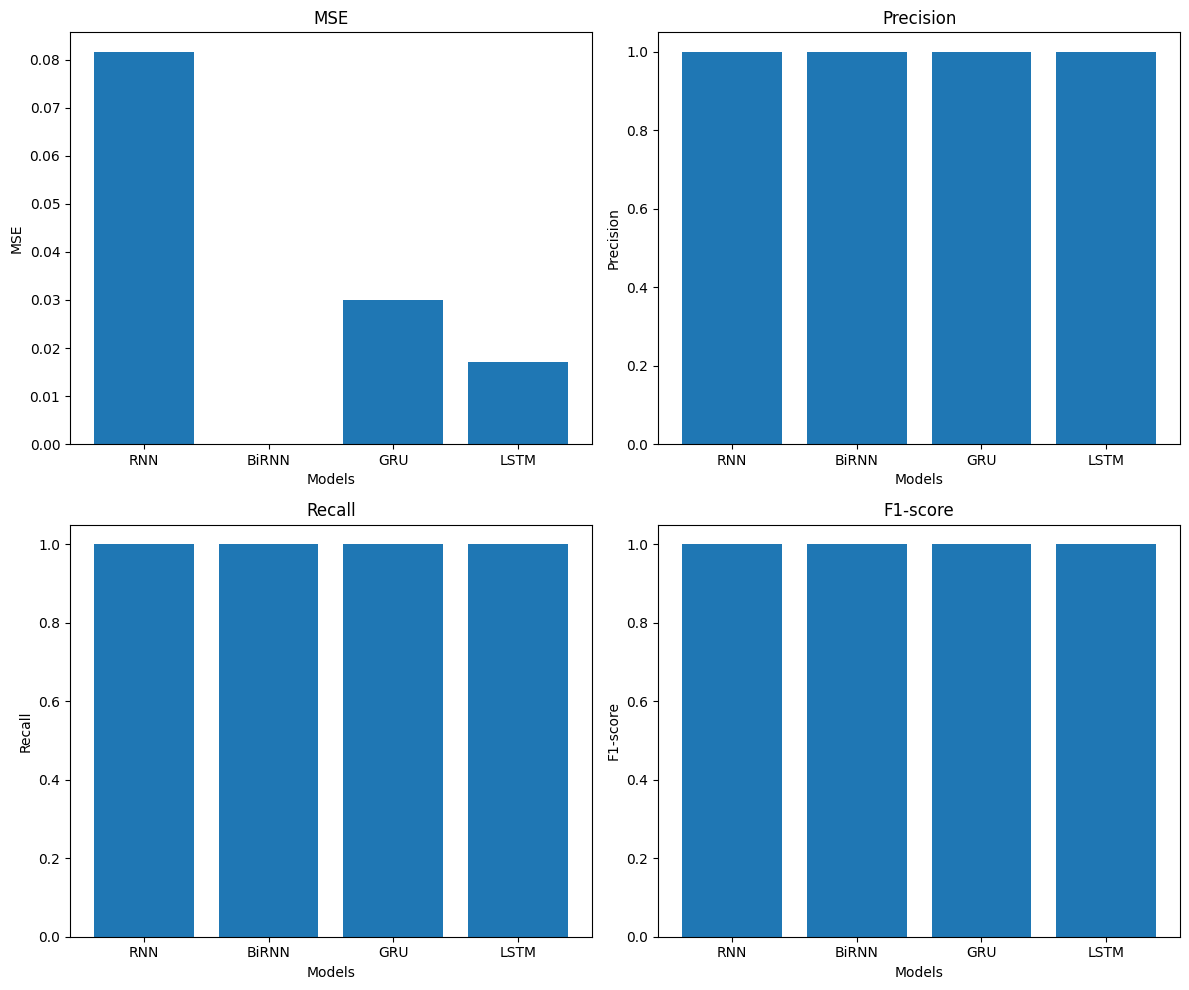

In [40]:

# Visualiser les résultats
plot_metrics([metrics["MSE"], metrics["Precision"], metrics["Recall"], metrics["F1"]], models)